# FIGURE M5: PREDICTING TUMOR INFILTRATION

In [17]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [1]:
import pickle 

with open('msresist/data/pickled_models/binomial/CPTACmodel_BINOMIAL_CL24_W15_TMT2', 'rb') as p:
    model = pickle.load(p)[0]

In [79]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]
centers = pd.DataFrame(model.transform())
centers.columns = np.arange(model.ncl) + 1
centers["Patient_ID"] = X.columns[4:]

In [80]:
from msresist.figures.figureM4 import find_patients_with_NATandTumor

# Import infiltration data
y = pd.read_csv("msresist/data/MS/CPTAC/xCellSign_minimal.csv").sort_values(by="Patient ID").dropna(axis=1)
centers = find_patients_with_NATandTumor(centers, "Patient_ID", conc=True)
y = find_patients_with_NATandTumor(y, "Patient ID", conc=False)
l1 = list(centers.index)
l2 = list(y.index)
dif = [i for i in l1 + l2 if i not in l1 or i not in l2]
centers = centers.drop(dif)
assert all(centers.index.values == y.index.values), "Samples don't match"
# Normnalize
centers.iloc[:, :] = StandardScaler(with_std=False).fit_transform(centers.iloc[:, :])
y.iloc[:, :] = StandardScaler().fit_transform(y.iloc[:, :])

## PCA

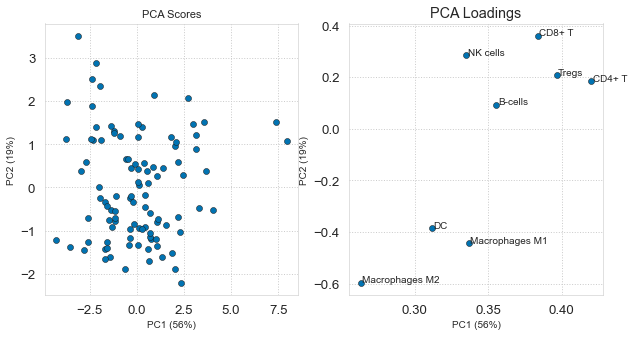

In [48]:
import matplotlib.pyplot as plt
from msresist.figures.figure3 import plotPCA

_, ax = plt.subplots(1, 2, figsize=(10, 5))

plotPCA(ax, y.reset_index(), 2, ["Patient ID"], "Cell Line", hue_scores=None, style_scores=None, style_load=None, legendOut=False)

## Multi-task LASSO

In [110]:
def plot_LassoCoef_Immune(ax, reg, centers, y, ncl, s_type="Tumor"):
    """Plot LASSO coefficients of centers explaining immune infiltration"""
    # Format data for seaborn
    coef = pd.DataFrame(reg.coef_.T)
    coef.columns = y.columns
    coef["Cluster"] = list(np.arange(24)) * 2
    coef["Sample"] = ["Tumor"] * ncl + ["NAT"] * ncl
    coef = pd.melt(coef, id_vars=["Cluster", "Sample"], value_vars=list(coef.columns[:-2]), var_name=["Cell Line"], value_name="Coefficient")

    if s_type:
        coef = coef[coef["Sample"] == s_type]
        ax.set_title(s_type + " samples driving Infiltration")
        sns.barplot(x="Cluster", y="Coefficient", hue="Cell Line", data=coef, ax=ax, **{"linewidth": 0.2}, **{"edgecolor": "black"})
    else:
        ax.set_title("Tumor and NAT samples driving Infiltration")
        sns.catplot(x="Cluster", y="Coefficient", hue="Cell Line", col="Sample", kind="bar", data=coef, ax=ax, **{"linewidth": 0.2}, **{"edgecolor": "black"})

    # Add r2 coef
    textstr = "$r2 score$ = " + str(np.round(r2_score(y, reg.predict(centers)), 4))
    props = dict(boxstyle="square", facecolor="none", alpha=0.5, edgecolor="black")
    ax.text(0.65, 0.10, textstr, transform=ax.transAxes, verticalalignment="top", bbox=props, fontsize=10)
    print(textstr)

$r2 score$ = 0.6204


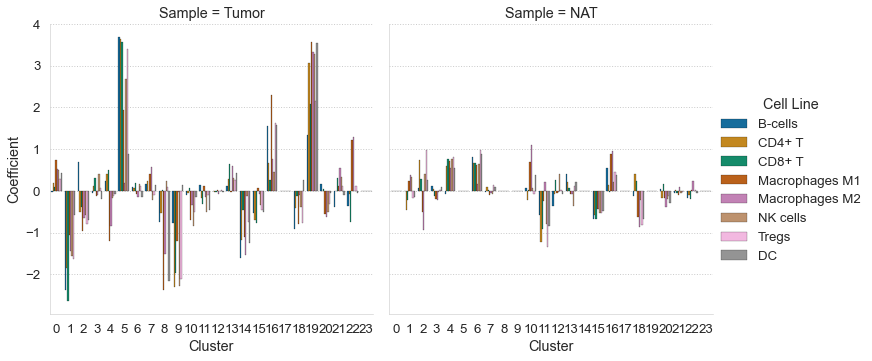

In [111]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.metrics import r2_score

reg = MultiTaskLassoCV(cv=10, 
                    max_iter=10000, tol=1e-6, 
                    n_jobs=-1
                    ).fit(centers, y)
plot_LassoCoef_Immune(ax, reg, centers, y, model.ncl, s_type=False)

## PLSR

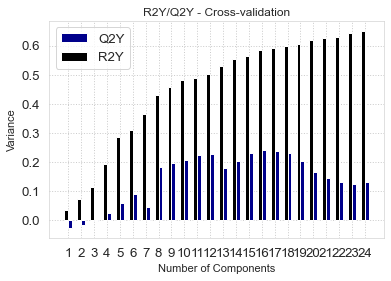

In [87]:
from sklearn.cross_decomposition import PLSRegression
from msresist.figures.figure3 import plotR2YQ2Y

_, ax = plt.subplots(1, 1)

plsr = PLSRegression(n_components=8, scale=False)
plotR2YQ2Y(ax, plsr, centers, y, model.ncl + 1)


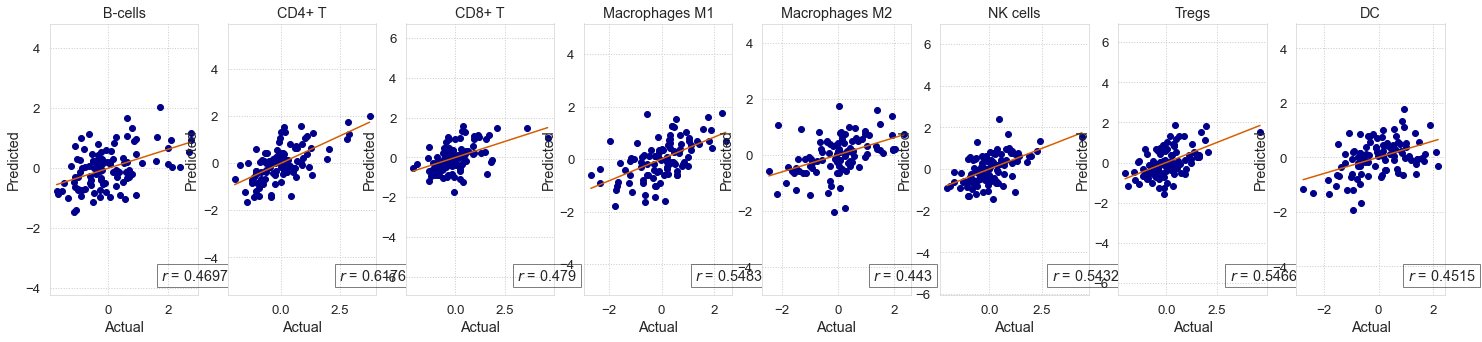

In [99]:
from msresist.figures.figure3 import plotActualVsPredicted

_, ax = plt.subplots(1, y.columns.size, figsize=(25, 5))
plsr = PLSRegression(n_components=12, scale=False)
plotActualVsPredicted(ax, plsr, centers, y)